In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display

import tensorflow as tf
print(tf. __version__)

2.10.0


In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf

In [3]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


In [4]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [5]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [6]:
q_rs = (np.arange(80)+1)*0.2
parameters = [0.42,0.02,21]
sq_GT = sq_rs[id_params(parameters),:][0]
sq_NN = SQ_NN(parameters)
sq_NN_GP = SQ_NN(parameters,GP=True)

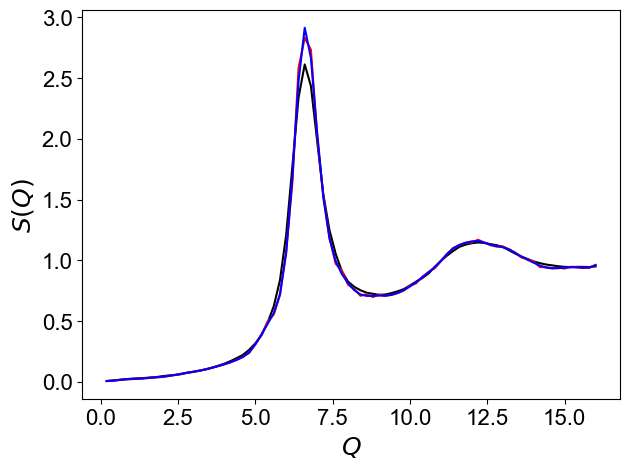

In [7]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
ax.plot(q_rs,sq_GT,'-k')
ax.plot(q_rs,sq_NN,'-r')
ax.plot(q_rs,sq_NN_GP,'-b')
ax.set_xlabel(r'$Q$',fontsize=18)
ax.set_ylabel(r'$S(Q)$',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()

In [8]:
list_eta = (np.arange(10))*0.015*3+0.015
list_kappa = (np.arange(9))*0.02*3+0.02
list_A = (np.arange(10))*1*2+1

parameters_grid = np.array([x.flatten() for x in np.meshgrid(list_eta,list_kappa,list_A)]).T
index_grid = np.array([id_params(p)[0] for p in parameters_grid])
sq_GT_grid = sq_rs[index_grid,:]

# speed test
from tqdm import tqdm
sq_NN_grid = []
for p in tqdm(parameters_grid):
    sq_NN_grid.append(SQ_NN_tf(p,GP=True))
sq_NN_grid = np.array(sq_NN_grid)    

# sq_NN_GP_grid = np.array([SQ_NN_tf(p,GP=True) for p in parameters_grid])

100%|████████████████████████████████████████████████████████████████████████████████████████| 900/900 [02:20<00:00,  6.41it/s]


In [9]:
def err_L2(x,y):
    return np.mean((x-y)**2)

err_grid = np.array([err_L2(sq_GT_grid[i],sq_NN_grid[i]) for i in range(len(index_grid))])

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


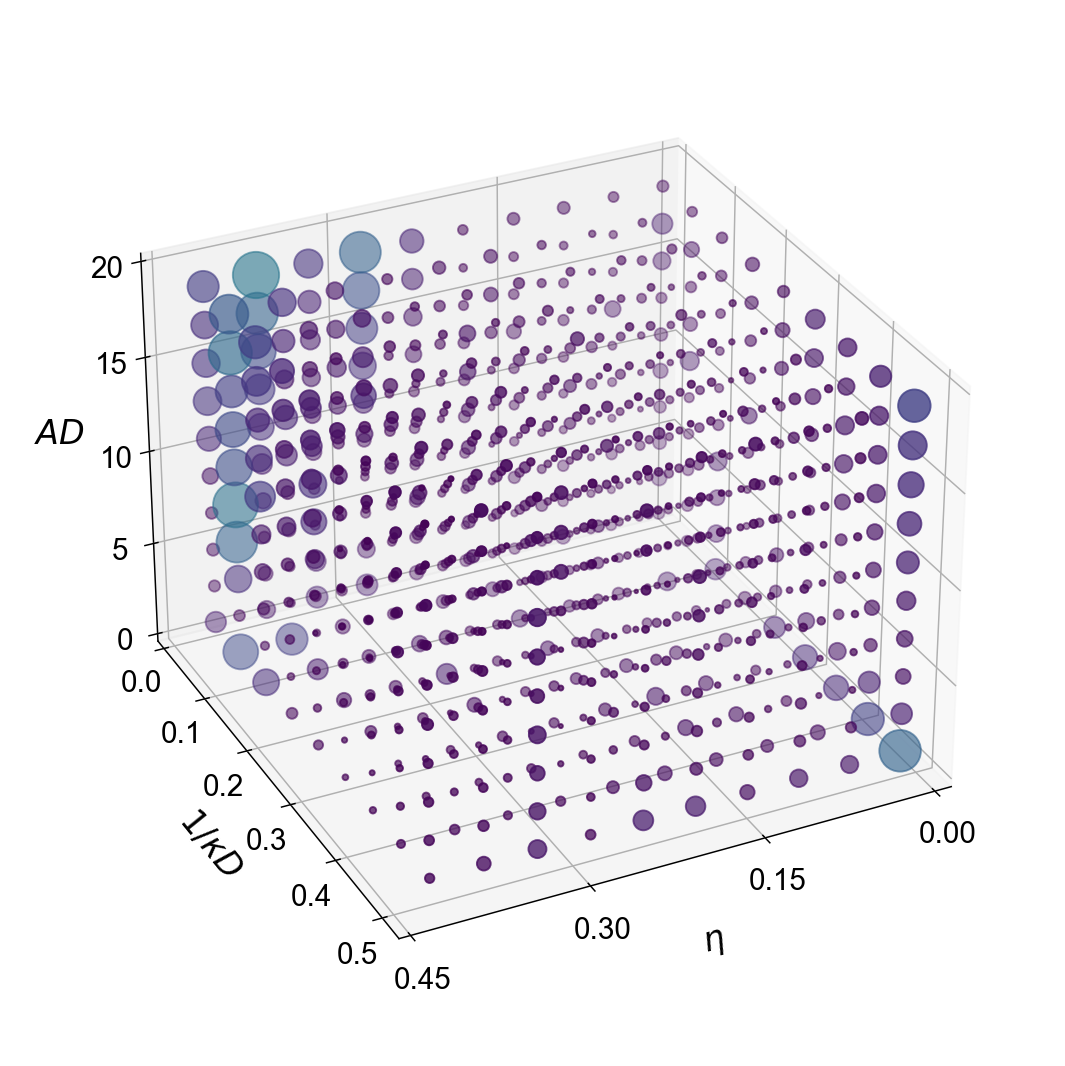

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=64)
ax.scatter(parameters_grid[:,0],parameters_grid[:,1],parameters_grid[:,2], 
           s=err_grid*1e5, c=err_grid, vmin=0, vmax=0.016,
           marker='o')

ax.set_xlabel(r'$\eta$',fontsize=18)
ax.set_ylabel(r'$1/\kappa D$',fontsize=18)
ax.set_zlabel(r'$AD$',fontsize=18)
ax.set_xticks([0.0,0.15,0.3,0.45])
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax.set_zticks([0,5,10,15,20])
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout(pad=2.5)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
plt.show()

<IPython.core.display.Javascript object>


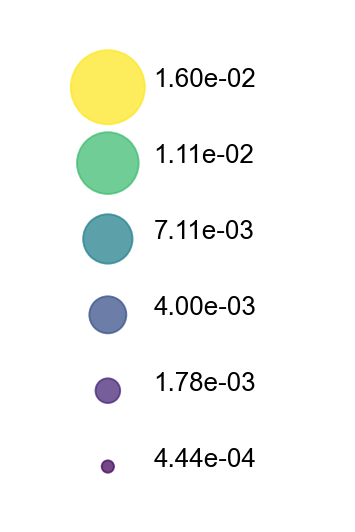

In [12]:
size = ((np.arange(6)+1)/6)**2*0.016

x = np.zeros(6)
y = np.arange(6)/2
z = np.zeros(6)

fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([1,6,1])
ax.scatter(x, y, z, 
           s=size*1e5, c=size, vmin=0, vmax=0.016, 
           marker='o',alpha=0.75)
for i,s in enumerate(size):
    ax.text(x[i]+0.4, y[i], z[i], 
           '{:0.2e}'.format(s),fontsize=14)

# ax.set_xlabel(r'$\eta$',fontsize=18)
# ax.set_ylabel(r'$1/\kappa D$',fontsize=18)
# ax.set_zlabel(r'$AD$',fontsize=18)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_ylim([-2,7])
ax.set_xlim([-1,1])
ax.set_zlim([-1,1])
ax.axis('off')
plt.tight_layout(pad=0)
plt.gca().set_position([-1.75, -1.2, 4, 4])
plt.show()